# 1. create own dataset for training:
- from own playing cards (captures of cards in video) 
- random backgrounds [Describable Backgrounds Dataset](https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz) 
- notebook [creating_playing_cards_dataset.ipynb](https://github.com/geaxgx/playing-card-detection) as guideline
- upload dataset to roboflow
    - convert to different formats (yolov5 on pytorch)

## 2.1 Train own approach from scratch in Keras

In [2]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten,Conv2D, MaxPooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd

In [3]:
#Data loader
NUM_CLASSES = 52
NUM_IMGS_TRAINING = 2000
NUM_IMGS_VALIDATION = 900
MODEL_SHAPE = (240,240)
NUM_CLASSES =52
NUM_EPOCHS = 100
def create_dataset_folder(folder, shape, size):
    label_folder = folder + "/labels/"
    img_folder = folder + "/images/"
    directory = os.fsencode(label_folder)
    data = []
    labels_class= np.zeros((4,size,1),dtype=int)
    labels_bbox = np.zeros((4,size,4))
    
    img_idx = 0
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        #stop because memory will not be enough
        if img_idx == size:
            break
        if filename.endswith(".txt"):
            img_path = img_folder+os.path.splitext(filename)[0]+".jpg" 
            img =cv2.imread(img_path, cv2.IMREAD_COLOR)
            img_res = cv2.resize(img, shape)
            data.append(img_res)
            
            label_all=pd.read_csv(label_folder+filename, delimiter =" ", header=None)#only first label
            for index, row in label_all.iterrows():
                labels_class[index,img_idx]=int(row[0])
                labels_bbox[index,img_idx] = np.array(row[1:5].tolist())   
            
        img_idx = img_idx+1
    data = np.array(data)/255
    print("Images: ", img_idx)
    return data, labels_class, labels_bbox


X_train, Y_train_classification, Y_train_bbox = create_dataset_folder("small_playing_cards_yolo/train", MODEL_SHAPE ,NUM_IMGS_TRAINING)
X_val, Y_val_classification, Y_val_bbox = create_dataset_folder("small_playing_cards_yolo/train", MODEL_SHAPE ,NUM_IMGS_VALIDATION)

Images:  2000
Images:  900


In [3]:
# CNN Part:
input = Input(shape=(240, 240, 3))
conv1 = Conv2D(64, kernel_size=4, activation='relu')(input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(32, kernel_size=4, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv2 = Conv2D(16, kernel_size=4, activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = Flatten()(pool3)

In [4]:
# Split in 8 branches
#classification1:
class1 = Dense(512, activation='relu') (flatten)
class1_output = Dense(52, activation='softmax',name="class_1") (class1)
#bounding box1:
bbox1 = Dense(128, activation="relu")(flatten)
bbox1 = Dense(64, activation="relu")(bbox1)
bbox1 = Dense(32, activation="relu")(bbox1)
bbox1_output = Dense(4, activation="sigmoid",
	name="bbox_1")(bbox1)


#classification2:
class2 = Dense(512, activation='relu') (flatten)
class2_output = Dense(52, activation='softmax',name="class_2") (class2)
#bounding box2:
bbox2 = Dense(128, activation="relu")(flatten)
bbox2 = Dense(64, activation="relu")(bbox2)
bbox2 = Dense(32, activation="relu")(bbox2)
bbox2_output = Dense(4, activation="sigmoid",
	name="bbox_2")(bbox2)


#classification3:
class3 = Dense(512, activation='relu') (flatten)
class3_output = Dense(52, activation='softmax',name="class_3") (class3)
#bounding box3:
bbox3 = Dense(128, activation="relu")(flatten)
bbox3 = Dense(64, activation="relu")(bbox3)
bbox3 = Dense(32, activation="relu")(bbox3)
bbox3_output = Dense(4, activation="sigmoid",
	name="bbox_3")(bbox3)


#classification4:
class4 = Dense(512, activation='relu') (flatten)
class4_output = Dense(52, activation='softmax',name="class_4") (class4)
#bounding box4:
bbox4 = Dense(128, activation="relu")(flatten)
bbox4 = Dense(64, activation="relu")(bbox4)
bbox4 = Dense(32, activation="relu")(bbox4)
bbox4_output = Dense(4, activation="sigmoid",
	name="bbox_4")(bbox4)

model = Model(
	inputs=input,
	outputs=(class1_output,class2_output,class3_output,class4_output, bbox1_output, bbox2_output, bbox3_output, bbox4_output)
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 237, 237, 64  3136        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 118, 118, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [4]:
losses = {
	"class_1": "sparse_categorical_crossentropy",
	"class_2": "sparse_categorical_crossentropy",
	"class_3": "sparse_categorical_crossentropy",
	"class_4": "sparse_categorical_crossentropy",
	"bbox_1": "mean_squared_error",
	"bbox_2": "mean_squared_error",
	"bbox_3": "mean_squared_error",
	"bbox_4": "mean_squared_error",
}

trainTargets = {
	"class_1": Y_train_classification[0],
	"class_2": Y_train_classification[1],
	"class_3": Y_train_classification[2],
	"class_4": Y_train_classification[3],
	"bbox_1": Y_train_bbox[0],
	"bbox_2": Y_train_bbox[1],
	"bbox_3": Y_train_bbox[2],
	"bbox_4": Y_train_bbox[3],
}
valTargets = {
	"class_1": Y_val_classification[0],
	"class_2": Y_val_classification[1],
	"class_3": Y_val_classification[2],
	"class_4": Y_val_classification[3],
	"bbox_1": Y_val_bbox[0],
	"bbox_2": Y_val_bbox[1],
	"bbox_3": Y_val_bbox[2],
	"bbox_4": Y_val_bbox[3],
}


In [68]:
name = "custom"
opt = Adam(learning_rate=0.001)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
model_save = tf.keras.callbacks.ModelCheckpoint('models/{}.h5'.format(name), save_best_only=True, monitor='val_loss', mode='min')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs_tb')

In [6]:

model.compile(loss=losses, optimizer=opt, metrics=["accuracy"]) #loss_weights=lossWeights)
H = model.fit(
	X_train, trainTargets,
	validation_data=(X_val, valTargets),
	batch_size=32,
	epochs=NUM_EPOCHS,
	verbose=1,
	callbacks = [es,model_save, tensorboard_callback])

Epoch 1/100
63/63 [==============================] - 14s 114ms/step - loss: 15.6879 - class_1_loss: 3.9676 - class_2_loss: 3.9664 - class_3_loss: 3.9593 - class_4_loss: 3.6625 - bbox_1_loss: 0.0258 - bbox_2_loss: 0.0242 - bbox_3_loss: 0.0284 - bbox_4_loss: 0.0537 - class_1_accuracy: 0.0160 - class_2_accuracy: 0.0230 - class_3_accuracy: 0.0310 - class_4_accuracy: 0.2255 - bbox_1_accuracy: 0.5075 - bbox_2_accuracy: 0.4935 - bbox_3_accuracy: 0.4810 - bbox_4_accuracy: 0.4830 - val_loss: 15.4578 - val_class_1_loss: 3.9433 - val_class_2_loss: 3.9380 - val_class_3_loss: 3.9319 - val_class_4_loss: 3.5530 - val_bbox_1_loss: 0.0193 - val_bbox_2_loss: 0.0163 - val_bbox_3_loss: 0.0159 - val_bbox_4_loss: 0.0402 - val_class_1_accuracy: 0.0289 - val_class_2_accuracy: 0.0289 - val_class_3_accuracy: 0.0389 - val_class_4_accuracy: 0.2333 - val_bbox_1_accuracy: 0.4844 - val_bbox_2_accuracy: 0.4922 - val_bbox_3_accuracy: 0.4856 - val_bbox_4_accuracy: 0.5733
Epoch 2/100
63/63 [=============================

In [6]:
metrics=model.evaluate(X_val, [Y_val_classification[0],Y_val_classification[1],Y_val_classification[2],Y_val_classification[3],Y_val_bbox[0],Y_val_bbox[1],Y_val_bbox[2],Y_val_bbox[3]])

29/29 [==============================] - 6s 28ms/step - loss: 0.0015 - class_1_loss: 8.2985e-06 - class_2_loss: 9.9100e-06 - class_3_loss: 1.6259e-05 - class_4_loss: 6.1833e-06 - bbox_1_loss: 2.7896e-04 - bbox_2_loss: 2.1690e-04 - bbox_3_loss: 3.4592e-04 - bbox_4_loss: 6.2415e-04 - class_1_accuracy: 1.0000 - class_2_accuracy: 1.0000 - class_3_accuracy: 1.0000 - class_4_accuracy: 1.0000 - bbox_1_accuracy: 0.9800 - bbox_2_accuracy: 0.9744 - bbox_3_accuracy: 0.9600 - bbox_4_accuracy: 0.8611


## 2.2 Use Transfer Learning in Keras

In [69]:
vgg = VGG16(weights="imagenet", include_top=False,input_shape=(240,240,3))
vgg.trainable = False
out_vgg = vgg.output
flatten = Flatten()(out_vgg)
flatten = Dense(512)(flatten)

In [70]:
# Split in 8 branches
#classification1:
class1 = Dense(512, activation='relu') (flatten)
class1_output = Dense(52, activation='softmax',name="class_1") (class1)
#bounding box1:
bbox1 = Dense(128, activation="relu")(flatten)
bbox1 = Dense(64, activation="relu")(bbox1)
bbox1 = Dense(32, activation="relu")(bbox1)
bbox1_output = Dense(4, activation="sigmoid",
	name="bbox_1")(bbox1)


#classification2:
class2 = Dense(512, activation='relu') (flatten)
class2_output = Dense(52, activation='softmax',name="class_2") (class2)
#bounding box2:
bbox2 = Dense(128, activation="relu")(flatten)
bbox2 = Dense(64, activation="relu")(bbox2)
bbox2 = Dense(32, activation="relu")(bbox2)
bbox2_output = Dense(4, activation="sigmoid",
	name="bbox_2")(bbox2)


#classification3:
class3 = Dense(512, activation='relu') (flatten)
class3_output = Dense(52, activation='softmax',name="class_3") (class3)
#bounding box3:
bbox3 = Dense(128, activation="relu")(flatten)
bbox3 = Dense(64, activation="relu")(bbox3)
bbox3 = Dense(32, activation="relu")(bbox3)
bbox3_output = Dense(4, activation="sigmoid",
	name="bbox_3")(bbox3)


#classification4:
class4 = Dense(512, activation='relu') (flatten)
class4_output = Dense(52, activation='softmax',name="class_4") (class4)
#bounding box4:
bbox4 = Dense(128, activation="relu")(flatten)
bbox4 = Dense(64, activation="relu")(bbox4)
bbox4 = Dense(32, activation="relu")(bbox4)
bbox4_output = Dense(4, activation="sigmoid",
	name="bbox_4")(bbox4)

model_tf = Model(
	inputs=vgg.input,
	outputs=(class1_output,class2_output,class3_output,class4_output, bbox1_output, bbox2_output, bbox3_output, bbox4_output)
)
model_tf.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 240, 240, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 240, 240, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [ ]:
name = "transfer_learning"
opt = Adam(learning_rate=0.001)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
model_save = tf.keras.callbacks.ModelCheckpoint('models/{}.h5'.format(name), save_best_only=True, monitor='val_loss', mode='min')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs_tb')

In [71]:
model_tf.compile(loss=losses, optimizer=opt, metrics=["accuracy"]) #loss_weights=lossWeights)
H_tf = model_tf.fit(
	X_train, trainTargets,
	validation_data=(X_val, valTargets),
	batch_size=32,
	epochs=NUM_EPOCHS,
	verbose=1,
	callbacks = [es, model_save,tensorboard_callback])

Epoch 1/100
63/63 [==============================] - 14s 183ms/step - loss: 21.3475 - class_1_loss: 5.2040 - class_2_loss: 5.6389 - class_3_loss: 5.3745 - class_4_loss: 4.9327 - bbox_1_loss: 0.0368 - bbox_2_loss: 0.0253 - bbox_3_loss: 0.0682 - bbox_4_loss: 0.0670 - class_1_accuracy: 0.0235 - class_2_accuracy: 0.0205 - class_3_accuracy: 0.0340 - class_4_accuracy: 0.1470 - bbox_1_accuracy: 0.5155 - bbox_2_accuracy: 0.5180 - bbox_3_accuracy: 0.5300 - bbox_4_accuracy: 0.5320 - val_loss: 12.9542 - val_class_1_loss: 3.5586 - val_class_2_loss: 3.4051 - val_class_3_loss: 3.1133 - val_class_4_loss: 2.7840 - val_bbox_1_loss: 0.0203 - val_bbox_2_loss: 0.0191 - val_bbox_3_loss: 0.0150 - val_bbox_4_loss: 0.0388 - val_class_1_accuracy: 0.1022 - val_class_2_accuracy: 0.2022 - val_class_3_accuracy: 0.2111 - val_class_4_accuracy: 0.3200 - val_bbox_1_accuracy: 0.5078 - val_bbox_2_accuracy: 0.5167 - val_bbox_3_accuracy: 0.6311 - val_bbox_4_accuracy: 0.5678
Epoch 2/100
63/63 [=============================

In [5]:
model = tf.keras.models.load_model("models/custom.h5")
model_tf = tf.keras.models.load_model("models/transfer_learning.h5")

In [6]:
metrics=model_tf.evaluate(X_val, [Y_val_classification[0],Y_val_classification[1],Y_val_classification[2],Y_val_classification[3],Y_val_bbox[0],Y_val_bbox[1],Y_val_bbox[2],Y_val_bbox[3]])

29/29 [==============================] - 8s 104ms/step - loss: 0.0026 - class_1_loss: 6.2779e-05 - class_2_loss: 6.0836e-05 - class_3_loss: 3.4543e-05 - class_4_loss: 2.5611e-05 - bbox_1_loss: 7.8746e-04 - bbox_2_loss: 5.1980e-04 - bbox_3_loss: 4.9018e-04 - bbox_4_loss: 6.2517e-04 - class_1_accuracy: 1.0000 - class_2_accuracy: 1.0000 - class_3_accuracy: 1.0000 - class_4_accuracy: 1.0000 - bbox_1_accuracy: 0.9689 - bbox_2_accuracy: 0.9589 - bbox_3_accuracy: 0.9478 - bbox_4_accuracy: 0.8611


# 3 Evaluation of results


In [34]:
names=['10c', '10d', '10h', '10s', '2c', '2d', '2h', '2s', '3c', '3d', '3h', '3s', '4c', '4d', '4h', '4s', '5c', '5d', '5h', '5s', '6c', '6d', '6h', '6s', '7c', '7d', '7h', '7s', '8c', '8d', '8h', '8s', '9c', '9d', '9h', '9s', 'Ac', 'Ad', 'Ah', 'As', 'Jc', 'Jd', 'Jh', 'Js', 'Kc', 'Kd', 'Kh', 'Ks', 'Qc', 'Qd', 'Qh', 'Qs']
def plot_test_sample(image,label_classification, label_bbox):
    img = image.copy()
    colors = [(255,0,0), (0,255,0), (0,0,255), (255,0,255)]
    for card in range(4):
        width = label_bbox[card,2]*img.shape[1]
        
        height = label_bbox[card,3]*img.shape[0]
        center_x =label_bbox[card,0]* img.shape[1]
        center_y =label_bbox[card,1]* img.shape[0]
        start = [int(center_x-width/2), int(center_y-height/2)]
        end = [int(center_x+width/2), int(center_y+height/2)]
        cv2.rectangle(img, start,end, colors[card], thickness= 1)
        cv2.putText(img, names[int(label_classification[card])], (int(center_x-0.5*width), int(center_y-height)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, colors[card], 1)

    return img
#Index for Validation sample
IDX = 50

## 3.1 Own Approach

In [28]:
metrics=model.evaluate(X_val, [Y_val_classification[0],Y_val_classification[1],Y_val_classification[2],Y_val_classification[3],Y_val_bbox[0],Y_val_bbox[1],Y_val_bbox[2],Y_val_bbox[3]])

29/29 [==============================] - 3s 85ms/step - loss: 0.0018 - class_1_loss: 7.2657e-05 - class_2_loss: 7.1931e-05 - class_3_loss: 3.9592e-05 - class_4_loss: 3.1388e-05 - bbox_1_loss: 4.3903e-04 - bbox_2_loss: 4.0500e-04 - bbox_3_loss: 3.8013e-04 - bbox_4_loss: 3.5660e-04 - class_1_accuracy: 1.0000 - class_2_accuracy: 1.0000 - class_3_accuracy: 1.0000 - class_4_accuracy: 1.0000 - bbox_1_accuracy: 0.9711 - bbox_2_accuracy: 0.9511 - bbox_3_accuracy: 0.9389 - bbox_4_accuracy: 0.8822


29/29 [==============================] - 2s 83ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


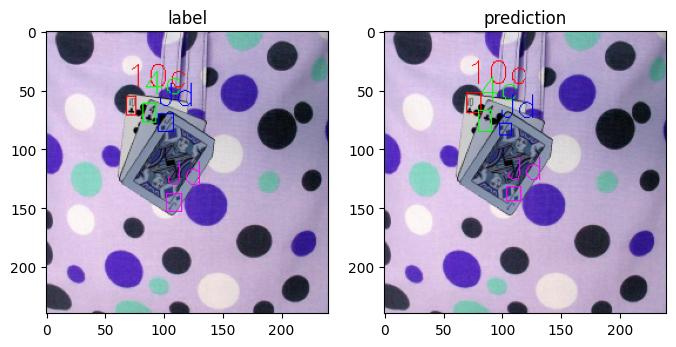

In [35]:
predictions = model.predict(X_val)

class_pred = np.zeros(4) 
class_pred[0] = np.argmax(predictions[0][IDX])
class_pred[1] = np.argmax(predictions[1][IDX])
class_pred[2] = np.argmax(predictions[2][IDX])
class_pred[3] = np.argmax(predictions[3][IDX])

bbox_pred = np.zeros((4,4))
bbox_pred[0] = predictions[4][IDX]
bbox_pred[1] = predictions[5][IDX]
bbox_pred[2] = predictions[6][IDX]
bbox_pred[3] = predictions[7][IDX]



fig = plt.figure(figsize=(8, 6))
plt.subplot(1,2,1)
plt.title("label")
plt.imshow(plot_test_sample(X_val[IDX], Y_train_classification[:,IDX], Y_train_bbox[:,IDX,:]))
plt.subplot(1,2,2)
plt.title("prediction")
plt.imshow(plot_test_sample(X_val[IDX], class_pred, bbox_pred))
plt.show()

## 3.2 Transfer Learning

In [ ]:
metrics=model_tf.evaluate(X_val, [Y_val_classification[0],Y_val_classification[1],Y_val_classification[2],Y_val_classification[3],Y_val_bbox[0],Y_val_bbox[1],Y_val_bbox[2],Y_val_bbox[3]])
predictions = model_tf.predict(X_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


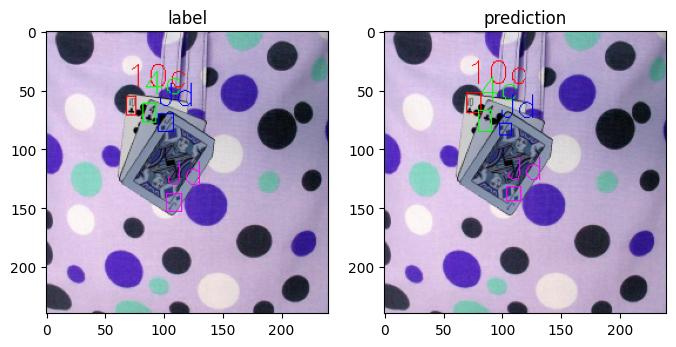

In [36]:

class_pred = np.zeros(4) 
class_pred[0] = np.argmax(predictions[0][IDX])
class_pred[1] = np.argmax(predictions[1][IDX])
class_pred[2] = np.argmax(predictions[2][IDX])
class_pred[3] = np.argmax(predictions[3][IDX])

bbox_pred = np.zeros((4,4))
bbox_pred[0] = predictions[4][IDX]
bbox_pred[1] = predictions[5][IDX]
bbox_pred[2] = predictions[6][IDX]
bbox_pred[3] = predictions[7][IDX]


fig = plt.figure(figsize=(8, 6))
plt.subplot(1,2,1)
plt.title("label")
plt.imshow(plot_test_sample(X_val[IDX], Y_train_classification[:,IDX], Y_train_bbox[:,IDX,:]))
plt.subplot(1,2,2)
plt.title("prediction")
plt.imshow(plot_test_sample(X_val[IDX], class_pred, bbox_pred))
plt.show()


# 3.3 Conclusion
Overall the Object Detection project in the course Computational Intelligence can be considered successful.

Firstly an own dataset was generated and annotated.
While the overall guideline for the dataset creation was given, the process was still very time consuming, especially recording each card by hand.
The dataset was then uploaded to roboflow.com. This made it possible to directly convert between data formats for different frameworks

As a state of the art comparison the dataset was first trained on the yolov5 with pytorch.
I will include the results of this trainingsrun for reference.
Using yolov5 made it clear that the dataset is in fact valid and can be used for an own custom object detection in Keras.

Next step was to write the data loader for Keras.
Here I decided to stick to the basics and parse through the directory.
The challenging part was to incorporate multiple labels for classification and bounding box regression to be able to do object detection

After that I decided to create a Keras Model completely from scratch.
The Model contains a CNN part and a fully connected part.
To be able to do object detection I used the Keras functional API and splitted the flattened CNN output to 8 different branches
The model is able to detect up to 4 objects with their class and bounding box.
The custom model already had very good performance, achieving almost perfect accuracy for classification and very good accuracy for bounding box regression.

To compare my model I tried to use transfer learning with the simple CNN Vgg-16.
The model with transfer learning only has around half the trainable parameters but still performs relatively good.
It would be very easy to use different CNNs for transfer learning like Resnet or xception as the fully connected part stays untouched.


